# Evaluate route origin validation status versus riswhois validity

This workbook evaluates the ROV status for all riswhois entries.
Then, for each RIPE Atlas probe, it matches the riswhois entries that match
the (v4/v6) address of each probe, and evaluates the rov status for the set
of announcements for each probe.

Finally it prints what probes are IPv4/IPv6 ROV invalid.

Along the way the workbook also prints multiple charts on riswhois visibility
and on ROV status.

In [1]:
# Add parent dir to path
import os,sys

sys.path.insert(0,os.environ['PWD'])

In [2]:
import bz2
import json
import ipaddress

import altair as alt
import pandas as pd
import requests

from rpki_analysis.routinator import read_jsonext
from rpki_analysis.riswhois import RisWhoisLookup, read_ris_dump
from rpki_analysis.rov import RouteOriginAuthorizationLookup, rov_validity, rov_validity_verbose

In [3]:
# https://www.ris.ripe.net/dumps/riswhoisdump.IPv4.gz
# https://www.ris.ripe.net/dumps/riswhoisdump.IPv6.gz
ris_v4_gz = requests.get("https://www.ris.ripe.net/dumps/riswhoisdump.IPv4.gz").content
ris_v6_gz = requests.get("https://www.ris.ripe.net/dumps/riswhoisdump.IPv6.gz").content


In [4]:
ris_v4 = read_ris_dump("https://www.ris.ripe.net/dumps/riswhoisdump.IPv4.gz")
ris_v6 = read_ris_dump("https://www.ris.ripe.net/dumps/riswhoisdump.IPv6.gz")

df_ris = pd.concat([ris_v4, ris_v6])

RIS dump contains row(s) with AS_SET! These will never be RPKI valid (https://tools.ietf.org/html/rfc6907#section-7.1.8)
RIS dump contains row(s) with AS_SET! These will never be RPKI valid (https://tools.ietf.org/html/rfc6907#section-7.1.8)


In [5]:
# Atlas Probe archive
atlas_probes_bz2 = requests.get("https://ftp.ripe.net/ripe/atlas/probes/archive/meta-latest").content
atlas_probes = pd.DataFrame(json.loads(bz2.decompress(atlas_probes_bz2))['objects'])

In [6]:
# > 200MB of data
rpki_roas = await read_jsonext("https://rpki-validator.ripe.net/jsonext")
# And add address family
rpki_roas['af'] = af = rpki_roas.prefix.map(lambda p: ipaddress.ip_network(p).version)
# And prefix length (to chart later)
rpki_roas['prefix_length'] = af = rpki_roas.prefix.map(lambda p: ipaddress.ip_network(p).prefixlen)


In [7]:
cnt = rpki_roas.groupby(['prefix', 'max_length']).count()
cnt[cnt.af > 2]

,,type,uri,tal,not_before,not_after,chain_not_before,chain_not_after,asn,af,prefix_length
prefix,max_length,,,,,,,,,,
1.22.36.0/24,24,3,3,3,3,3,3,3,3,3,3
1.23.62.0/24,24,3,3,3,3,3,3,3,3,3,3
100.20.0.0/14,24,3,3,3,3,3,3,3,3,3,3
100.24.0.0/13,24,3,3,3,3,3,3,3,3,3,3
100.42.64.0/20,24,4,4,4,4,4,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...
99.84.0.0/16,24,3,3,3,3,3,3,3,3,3,3
99.85.128.0/17,24,3,3,3,3,3,3,3,3,3,3
99.86.0.0/16,24,3,3,3,3,3,3,3,3,3,3


In [8]:
## these objects allow for lookup of the VRPs, ie  roa_lookup_v4[ <pfx> ] -> set of VRP objects
roa_lookup = RouteOriginAuthorizationLookup(rpki_roas)

In [9]:
# This prefix has a ROA for a less specific
roa_lookup['1.0.0.0/24']

{RouteOriginAuthorization(asn=13335, prefix='1.0.0.0/24', max_length=24, prefix_length=24)}

In [10]:
# Check that some known-valid space is valid
display(roa_lookup['193.0.0.0/21'])
display(rov_validity(ris_v4[ris_v4.prefix == '193.0.0.0/21'].iloc[0], roa_lookup))
ris_v4[ris_v4.prefix == '193.0.0.0/21'].iloc[0]

{RouteOriginAuthorization(asn=3333, prefix='193.0.0.0/21', max_length=21, prefix_length=21)}

'valid'

origin                   3333
prefix           193.0.0.0/21
seen_by_peers           413.0
prefix_length              21
Name: 892332, dtype: object

### Data has been loaded

Spot-check a sample from the roas in the prefix tries for both address families. Filter so it is a sample not from the most-common prefix length.

Starting with IPv4:

In [11]:
rpki_roas.describe()

,asn,max_length,af,prefix_length
count,5.188030e+05,518803.000000,518803.000000,518803.000000
mean,2.233279e+05,27.350241,4.369751,26.432459
std,2.500268e+07,9.846349,0.776394,8.846912
min,0.000000e+00,8.000000,4.000000,8.000000
25%,1.336700e+04,24.000000,4.000000,22.000000
50%,3.498400e+04,24.000000,4.000000,24.000000
75%,1.314290e+05,24.000000,4.000000,24.000000
max,4.294967e+09,128.000000,6.000000,128.000000


In [12]:
sample = rpki_roas[rpki_roas.prefix_length != 24].sample(5).reset_index()
display(sample)

,index,type,uri,tal,not_before,not_after,chain_not_before,chain_not_after,asn,prefix,max_length,af,prefix_length
0,514587,roa,rsync://rpki.ripe.net/repository/DEFAULT/c8/89...,ripe,2024-01-25T17:25:11Z,2025-07-01T00:00:00Z,2024-01-31T15:34:06Z,2024-07-01T00:00:00Z,48152,2a10:3202::/32,48,6,32
1,96032,roa,rsync://rpki.arin.net/repository/arin-rpki-ta/...,arin,2021-02-19T05:00:00Z,2027-02-12T05:00:00Z,2024-01-30T16:17:49Z,2025-10-22T00:45:16Z,33363,71.44.192.0/19,19,4,19
2,27688,roa,rsync://rpki.arin.net/repository/arin-rpki-ta/...,arin,2023-08-27T12:00:00Z,2024-10-31T04:00:00Z,2024-01-30T16:17:49Z,2024-10-31T04:00:00Z,396982,35.222.248.0/21,21,4,21
3,108070,roa,rsync://rpki.arin.net/repository/arin-rpki-ta/...,arin,2023-11-17T17:31:39Z,2024-02-15T17:31:39Z,2024-01-30T16:17:49Z,2024-02-15T17:31:39Z,33660,76.149.168.0/22,22,4,22
4,48233,roa,rsync://rpki.apnic.net/member_repository/A918E...,apnic,2023-11-30T07:25:24Z,2024-07-01T00:00:00Z,2024-02-02T00:02:36Z,2024-05-02T09:05:49Z,133283,45.114.36.0/22,24,4,22


In [13]:
roa_lookup[sample.prefix[0]]

{RouteOriginAuthorization(asn=48152, prefix='2a10:3202::/32', max_length=48, prefix_length=32)}

The printed entry should match the `prefix_length` in the top row of the table.

<Axes: ylabel='Frequency'>

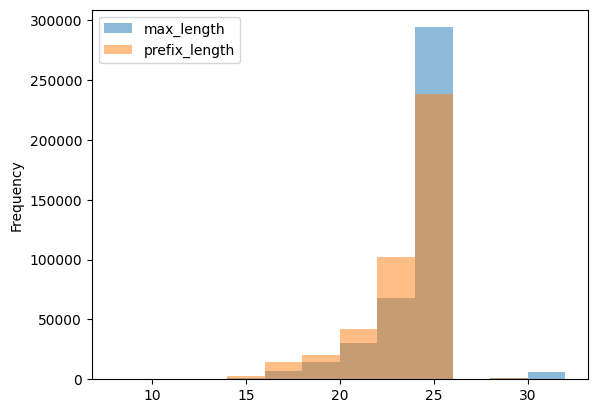

In [14]:
rpki_roas[rpki_roas.af == 4][['max_length', 'prefix_length']].plot.hist(
    bins=12,
    alpha=0.5
)

And now IPv6, again skipping what is likely the most common prefix_length

In [15]:
sample = rpki_roas[(rpki_roas.prefix_length != 48) & (rpki_roas.af == 6)].sample(5).reset_index()
display(sample)

,index,type,uri,tal,not_before,not_after,chain_not_before,chain_not_after,asn,prefix,max_length,af,prefix_length
0,504045,roa,rsync://rpki-rps.arin.net/repository/8a848adf8...,ripe,2023-03-15T12:47:54Z,2024-03-13T12:52:54Z,2024-01-31T15:34:06Z,2024-03-13T12:52:54Z,202776,2a06:a005:2b90::/44,48,6,44
1,479531,roa,rsync://repository.lacnic.net/rpki/lacnic/599d...,lacnic,2024-01-25T15:47:34Z,2026-01-25T15:47:34Z,2024-01-25T15:47:34Z,2025-01-30T17:34:46Z,52468,2803:9590:2000::/36,36,6,36
2,499558,roa,rsync://rpki.ripe.net/repository/DEFAULT/d1/5d...,ripe,2024-01-02T06:31:57Z,2025-07-01T00:00:00Z,2024-01-31T15:34:06Z,2024-07-01T00:00:00Z,48252,2a04:11c0::/29,29,6,29
3,470265,roa,rsync://rpki.arin.net/repository/arin-rpki-ta/...,arin,2023-11-14T14:00:20Z,2024-02-12T14:00:20Z,2024-01-30T16:17:49Z,2024-02-12T14:00:20Z,3653,2602:fc2d::/36,48,6,36
4,463855,roa,rsync://rpki.apnic.net/member_repository/A91A6...,apnic,2023-09-14T23:00:30Z,2024-10-31T00:00:00Z,2024-01-18T05:15:55Z,2024-05-02T09:05:49Z,136969,2406:f480:0:1::/64,64,6,64


<Axes: ylabel='Frequency'>

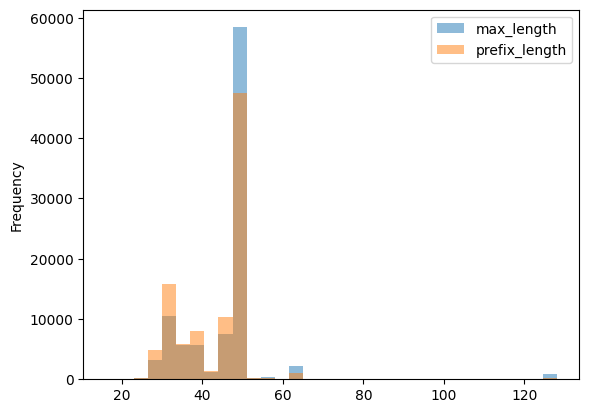

In [16]:
rpki_roas[rpki_roas.af == 6][['max_length', 'prefix_length']].plot.hist(
    bins=32,
    alpha=0.5
)

All data has been collected.

In [17]:
ris_v4

,origin,prefix,seen_by_peers,prefix_length
16,3257,0.0.0.0/0,1.0,0
17,58057,0.0.0.0/0,1.0,0
18,55720,0.0.0.0/0,2.0,0
19,50628,0.0.0.0/0,2.0,0
20,34927,0.0.0.0/0,1.0,0
...,...,...,...,...
1135004,58519,223.255.253.0/24,383.0,24
1135005,55415,223.255.254.0/24,393.0,24
1135006,58224,223.255.254.0/24,7.0,24
1135007,58224,223.255.255.0/24,23.0,24


In [18]:

ris_v4.sample(10).apply(lambda x: rov_validity(x, roa_lookup), axis=1)

307084     unknown
810811       valid
987647       valid
1003895      valid
689413     unknown
417489       valid
885239     unknown
211109     unknown
748089     unknown
1067734    unknown
dtype: object

In [19]:
ris_v4['roa_validity'] = ris_v4.apply(lambda x: rov_validity(x, roa_lookup), axis=1)
ris_v6['roa_validity'] = ris_v6.apply(lambda x: rov_validity(x, roa_lookup), axis=1)


In [20]:
ris_v4['roa_validity'].value_counts()

unknown    589828
valid      503998
invalid     41167
Name: roa_validity, dtype: int64

In [21]:
# And build patricia trie
ris_v4_lookup = RisWhoisLookup(ris_v4)
ris_v6_lookup = RisWhoisLookup(ris_v6)

In [22]:
ris_v4[ris_v4.roa_validity == "invalid"].sample(20)

,origin,prefix,seen_by_peers,prefix_length,roa_validity
277510,200664,81.25.191.68/32,1.0,32,invalid
276918,200664,81.25.185.243/32,1.0,32,invalid
930476,21491,196.0.106.0/24,30.0,24,invalid
618536,32653,154.72.100.200/29,1.0,29,invalid
286057,16010,82.211.165.160/27,1.0,27,invalid
930462,21491,196.0.79.0/24,30.0,24,invalid
296076,12715,85.57.232.0/22,1.0,22,invalid
1091658,16010,213.157.202.25/32,1.0,32,invalid
330469,12715,90.167.181.0/24,1.0,24,invalid
861266,262195,190.90.201.0/24,1.0,24,invalid


In [23]:
# Take the RPKI smiley range, from https://sg-pub.ripe.net/jasper/rpki-web-test/
# and lookup what it is announced by
# e.g. `whois -h riswhois.ripe.net 209.24.0.3`
# the announcement is for 209.24.0.0/24
display(ris_v4[(ris_v4.roa_validity == "invalid") & (ris_v4.prefix == '209.24.0.0/24')])
# or:
ris_v4_lookup['209.24.0.3']

,origin,prefix,seen_by_peers,prefix_length,roa_validity
1055621,15562,209.24.0.0/24,142.0,24,invalid


{ExpandedRisEntry(origin='15562', prefix='209.24.0.0/24', seen_by_peers=142.0, prefix_length=24, roa_validity='invalid')}

In [24]:
def is_in_valid_v4(prefix: str):
    if not prefix:
        return None
    was_unknown = False

    lookup = ris_v4_lookup[prefix]
    if not lookup:
        return None
    
    for route in lookup:
        has_route = True
        if route.roa_validity == 'valid':
            return "valid"
        if route.roa_validity == 'unknown':
            was_unknown = True
                
    return "unknown" if was_unknown else "invalid"

def is_in_valid_v6(prefix: str):
    if not prefix:
        return None
    was_unknown = False

    if prefix == "::2":
        return False

    lookup = ris_v6_lookup[prefix]
    if not lookup:
        return None
    
    for route in lookup:
        if route.roa_validity == 'valid':
            return "valid"
        if route.roa_validity == 'unknown':
            was_unknown = True
            
    return "unknown" if was_unknown else "invalid"

In [25]:
# Invalid
display(is_in_valid_v4("209.24.0.3"))
# valid
display(is_in_valid_v4("193.0.1.6"))
# Unknown
display(is_in_valid_v4("138.204.43.1"))

'invalid'

'valid'

'valid'

# Process the atlas probes

In [26]:
atlas_probes['address_v4_rov'] = atlas_probes.address_v4.map(is_in_valid_v4)
atlas_probes['address_v6_rov'] = atlas_probes.address_v6.map(is_in_valid_v6)

In [27]:
atlas_probes[atlas_probes.address_v6 == "::2"]

,id,address_v4,address_v6,asn_v4,asn_v6,prefix_v4,prefix_v6,is_anchor,is_public,status,...,total_uptime,tags,country_code,latitude,longitude,day,probe,status_name,address_v4_rov,address_v6_rov
20189,30326,169.155.255.22,::2,14593.0,NaN,169.155.252.0/22,None,False,True,1,...,221703137,"[system-dns-problem-suspected, system-ipv4-sta...",FR,48.1405,-1.9515,20240201,https://atlas.ripe.net/api/v2/probes/30326/,Connected,valid,False
31880,1002088,82.118.234.154,::2,203380.0,NaN,82.118.234.0/24,None,False,True,3,...,25840551,"[system-ipv6-capable, system-ipv4-rfc1918, sys...",BG,42.7015,23.3215,20240201,https://atlas.ripe.net/api/v2/probes/1002088/,Abandoned,valid,False
32530,1002808,102.70.65.33,::2,37294.0,NaN,102.70.64.0/22,None,False,True,3,...,2599616,"[system-ipv6-capable, system-ipv4-rfc1918, sys...",ZA,-33.9485,18.4675,20240201,https://atlas.ripe.net/api/v2/probes/1002808/,Abandoned,valid,False


In [28]:
atlas_probes[(atlas_probes.address_v4_rov == 'invalid')]

,id,address_v4,address_v6,asn_v4,asn_v6,prefix_v4,prefix_v6,is_anchor,is_public,status,...,total_uptime,tags,country_code,latitude,longitude,day,probe,status_name,address_v4_rov,address_v6_rov
20378,30567,93.185.31.95,None,12389.0,NaN,93.185.31.0/24,None,False,True,3,...,86181358,"[system-v3, system-ipv4-capable, system-ipv4-r...",RU,59.9305,30.3405,20240201,https://atlas.ripe.net/api/v2/probes/30567/,Abandoned,invalid,None


In [29]:
active_probes_v4_or_v6_invalid = atlas_probes[((atlas_probes.address_v4_rov == 'invalid') | (atlas_probes.address_v6_rov == 'invalid')) & (atlas_probes.status_name != 'Abandoned')]

In [30]:
if not active_probes_v4_or_v6_invalid.empty:
    active_probes_v4_or_v6_invalid.sample(5)

In [31]:
atlas_probes[((atlas_probes.address_v4_rov == 'invalid')) & (atlas_probes.status_name != 'Abandoned')]

,id,address_v4,address_v6,asn_v4,asn_v6,prefix_v4,prefix_v6,is_anchor,is_public,status,...,total_uptime,tags,country_code,latitude,longitude,day,probe,status_name,address_v4_rov,address_v6_rov


In [32]:
# ris_v4[['roa_validity', 'seen_by_peers']].plot.hist(
#     by='seen_by_peers',
#     bins=16,
#     alpha=0.5
# )


seen_by_peers_count_by_roa_validity = ris_v4.groupby(['roa_validity', 'seen_by_peers'], as_index=False).agg({'prefix': 'count'})

rov_chart = alt.Chart(
    seen_by_peers_count_by_roa_validity).mark_bar()\
.encode(
    alt.X("seen_by_peers:Q", bin=False),
    alt.Color("roa_validity:N"),
    y='prefix',
).properties(
    title='Visibility versus ROV status',
    width=300,
    height=150,
).facet(
    column='roa_validity',
).resolve_scale(
    y='independent'
)

#rov_chart.save("ris_v4_rov_chart.png")
display(rov_chart)

alt.FacetChart(...)